In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.cwl2_attack import CWL2Attack

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [45]:
exp_id = 3

model_name = 'mnist_exp%d.h5' % exp_id
net = BasicModel()

In [46]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU(inplace)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (relu2): ReLU(inplace)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (relu4): ReLU(inplace)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (relu5): ReLU(inplace)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [15]:
with torch.no_grad():
    y_pred = net(x_test.cuda()).cpu()
    correc_idx = np.where(y_pred.argmax(1) == y_test)[0]
    print('Test acc: ', (y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))

Test acc:  0.9938


---

1 random noise per sample

In [17]:
std = 1e-1

In [20]:
with torch.no_grad():
    rnd = torch.randn_like(x_test) * std
    y_pred = net(x_test.cuda() + rnd.cuda()).cpu()
    correc_idx = np.where(y_pred.argmax(1) == y_test)[0]
    print('Test acc w/ noise: ', (y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))

Test acc w/ noise:  0.9918


In [81]:
acc = []
stds = 10 ** np.arange(-2, 1, 0.1)

for std in stds:
    
    with torch.no_grad():
        rnd = torch.randn_like(x_test) * std
        y_pred = net(x_test.cuda() + rnd.cuda()).cpu()
        acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))

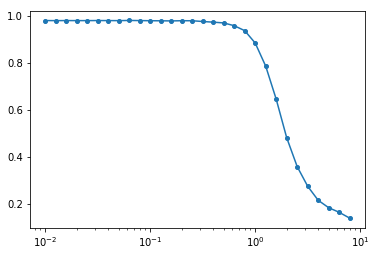

In [88]:
plt.plot(stds, acc, 'o-', markersize=4)
plt.xscale('log')
plt.show()

In [96]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(4):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_test) * std
            y_pred = net(x_test.cuda() + rnd.cuda()).cpu()
            acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))
    accs.append(acc)

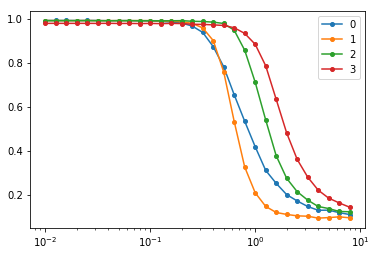

In [97]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=i, markersize=4)
plt.xscale('log')
plt.legend()
plt.show()

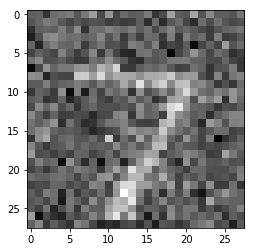

In [71]:
plt.imshow((x_test[0] + rnd[0] * 2).squeeze().numpy(), cmap='gray')

N random noises per sample

In [ ]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)
num_rnd = 1e3

for i in range(4):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        acc_sum = 0
        for j in range(x_test.size(0)):
            with torch.no_grad():
                rnd = torch.randn((int(num_rnd), 1, 28, 28)) * std
                y_pred = net(x_test[j].cuda() + rnd.cuda()).cpu()
                acc_sum += ((y_pred.argmax(1) == y_test[j]).sum().numpy() / num_rnd)
        acc.append(acc_sum / x_test.size(0))
    accs.append(acc)

In [ ]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=i, markersize=4)
plt.xscale('log')
plt.legend()
plt.show()